In [1]:
import tensorflow as tf
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.gain.basic2 import Basic2
from psychrnn.backend.gain.loss import rt_mask_mse_06, rt_mask_mse_07, rt_mask_mse_08
from psychrnn.tasks.checker import Checkerboard2AFC

from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


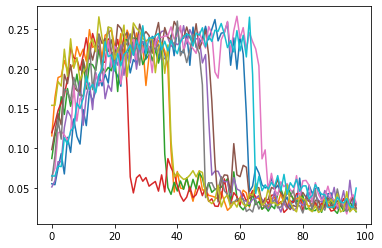

In [2]:
# plot losses for all 10 rounds of a given noise
for i in range(10):
    readFileName = "./losses/basic2_recNoise2round" + str(i) + ".txt"
    df = pd.read_csv(readFileName, delimiter = "\t")
    plt.plot(df)
    
    
# [0.5, 1, 1.5, 2, 2.2, 2.4, 2.6, 2.8, 3]



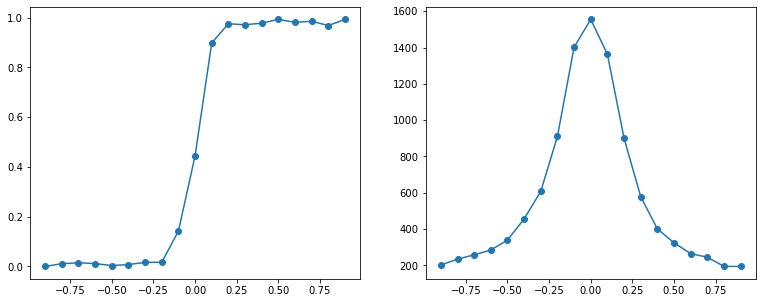

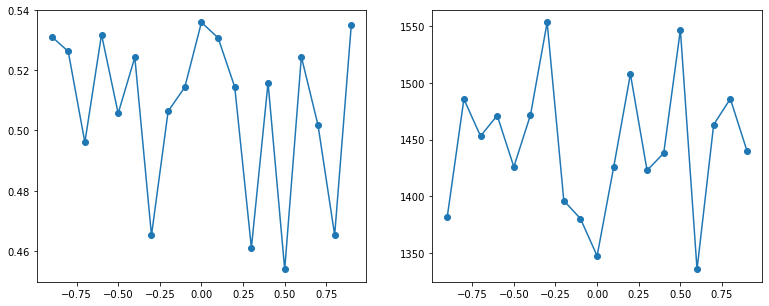

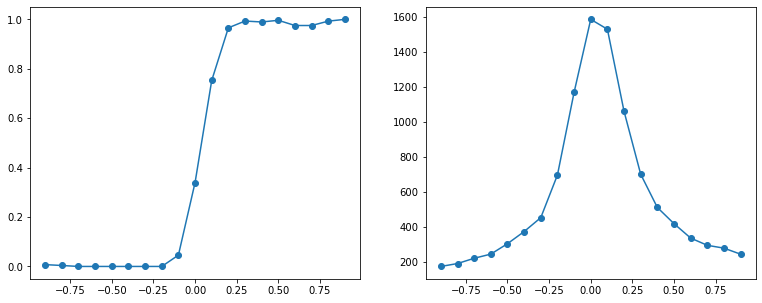

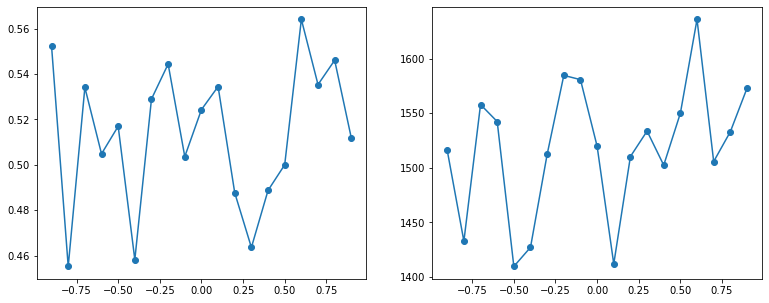

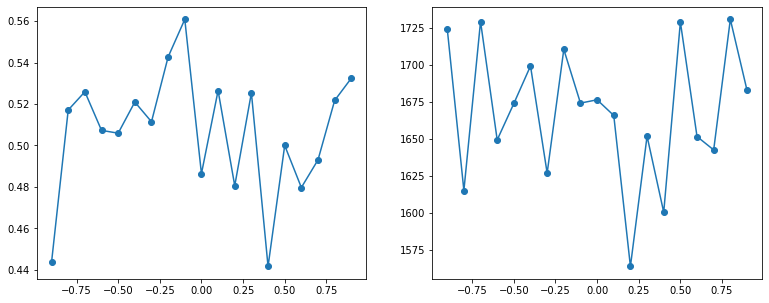

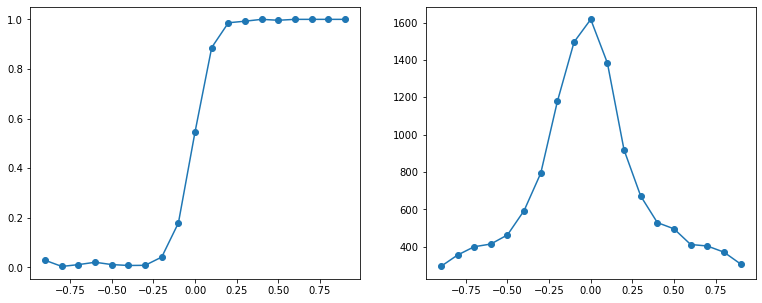

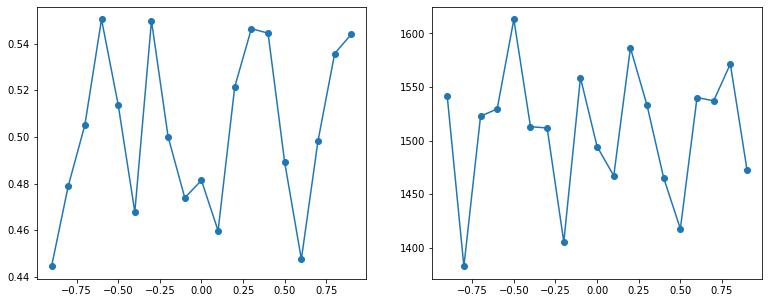

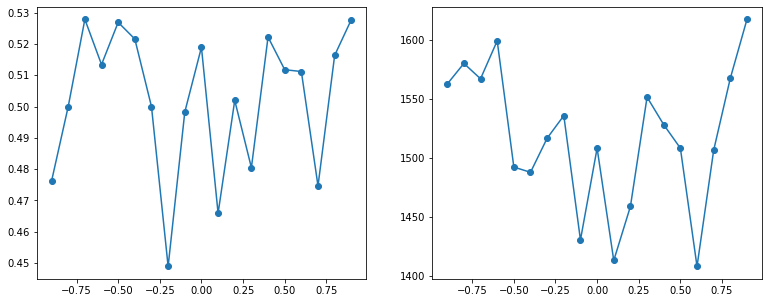

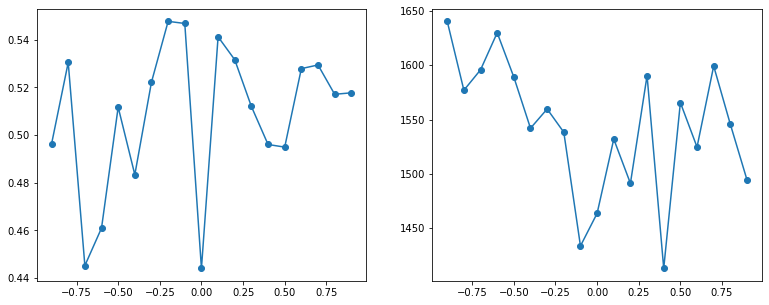

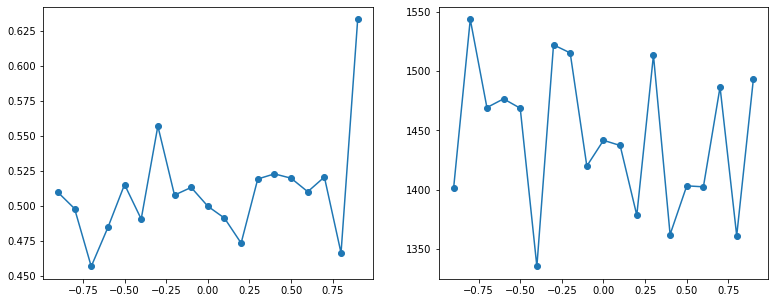

In [4]:
# plot session summary for all 10 rounds of a given noise
for i in range(10):
    resultFile = "./resultData/summary_recNoise2.4round" + str(i) + ".csv"
    checker_df = pd.read_csv(resultFile)

    checker_mean = checker_df.groupby('coherence_bin').mean().reset_index()

    plt.figure(figsize=(13, 5))
    plt.subplot(1,2,1)
    plt.plot(checker_mean['coherence_bin'], checker_mean['green_decision'])
    plt.scatter(checker_mean['coherence_bin'], checker_mean['green_decision'])

    plt.subplot(1,2,2)
    plt.plot(checker_mean['coherence_bin'], checker_mean['decision_time'])
    plt.scatter(checker_mean['coherence_bin'], checker_mean['decision_time'])


In [133]:
dt = 10
tau = 50
T = 3000
N_batch = 50
N_rec = 100
experiment = 'interactive'
name = 'basic'


rec_noise = 2
round = 1
thres = 0.8
weightsPath = "./weights/basic2_recNoise" + str(rec_noise) + "round" + str(round) + ".npz"

task = Checkerboard2AFC(dt=dt, tau=tau, T=T, N_batch=N_batch)

network_params = task.get_task_params()
network_params['name'] = name
network_params['N_rec'] = N_rec
network_params['rec_noise'] = rec_noise

network_params["transfer_function"] = tf.nn.relu
network_params["output_transfer_function"] = tf.nn.sigmoid
network_params["loss_function"] = "rt_mask_mse"
if thres == 0.6:
    network_params["rt_mask_mse"] = rt_mask_mse_06
elif thres == 0.7:
    network_params["rt_mask_mse"] = rt_mask_mse_07
elif thres == 0.8:
    network_params["rt_mask_mse"] = rt_mask_mse_08
        
network_params['load_weights_path'] =  weightsPath
model2 = Basic2(network_params)

# Generate 5000 testing trials

In [134]:
trials = 5000
batches = int(np.ceil(trials / N_batch))

rnn_state = np.zeros((trials, task.N_steps, model2.N_rec))
rnn_out = np.zeros((trials, task.N_steps, model2.N_out))

coherence = np.zeros(trials)
green_side = np.zeros(trials)
target_onset = np.zeros(trials)
checker_onset = np.zeros(trials)
decision = np.zeros(trials)
rt = np.zeros(trials)

for b in tqdm(range(batches)):
    x, y, m, params = task.get_trial_batch()
    outputs, states, inputs = model2.test(x)
    
    start_index = N_batch * b
    end_index = N_batch * (b + 1)
    rnn_state[start_index:end_index] = states
    rnn_out[start_index:end_index] = outputs
    
    thr = np.where(outputs > thres)
    
    for i in range(N_batch):
        index = start_index + i
        
        coherence[index] = params[i]["coherence"]
        green_side[index] = params[i]["side"]
        target_onset[index] = params[i]["target_onset"]
        checker_onset[index] = params[i]["checker_onset"]
        
        thr_time = thr[1][thr[0]==i][0] if sum(thr[0]==i) > 0 else outputs.shape[1]
        thr_unit = thr[2][thr[0]==i][0] if sum(thr[0]==i) > 0 else np.argmax(outputs[i, -1])
        decision[index] = thr_unit
        rt[index] = thr_time*task.dt - target_onset[index] - checker_onset[index]       

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.15it/s]


# Store result into a dataframe

In [135]:
correct_side = np.array([gs if coh > 0 else abs(gs-1) for coh, gs in zip(coherence, green_side)])
green_decision = np.array([int(dec == gs) for dec, gs in zip(decision, green_side)])
checker_df = pd.DataFrame({'trial' : np.arange(trials),
                           'coherence' : coherence,
                           'coherence_bin' : np.round(coherence, 1),
                           'green_side' : green_side,
                           'correct_side' : correct_side,
                           'target_onset' : target_onset,
                           'checker_onset' : checker_onset,
                           'decision' : decision,
                           'green_decision' : green_decision,
                           'decision_time' : rt,
                           'correct_decision' : (decision == correct_side).astype(int)})
checker_mean = checker_df.groupby('coherence_bin').mean().reset_index()


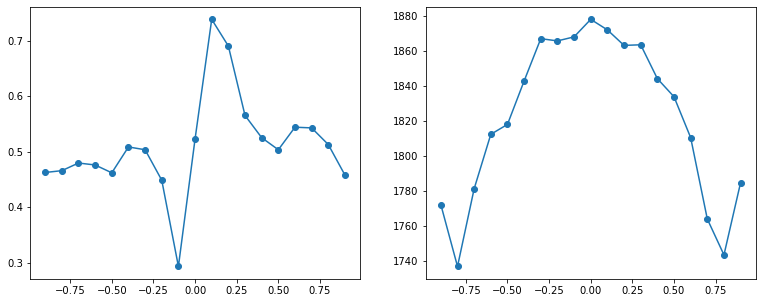

In [136]:
plt.figure(figsize=(13, 5))
plt.subplot(1,2,1)
plt.plot(checker_mean['coherence_bin'], checker_mean['green_decision'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['green_decision'])

plt.subplot(1,2,2)
plt.plot(checker_mean['coherence_bin'], checker_mean['decision_time'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['decision_time'])

# plt.savefig("rec_noise" + str(rec_noise) + "round" + str(round) + "train0.7test" + str(thres) + ".png")


# RT within coherence bin 

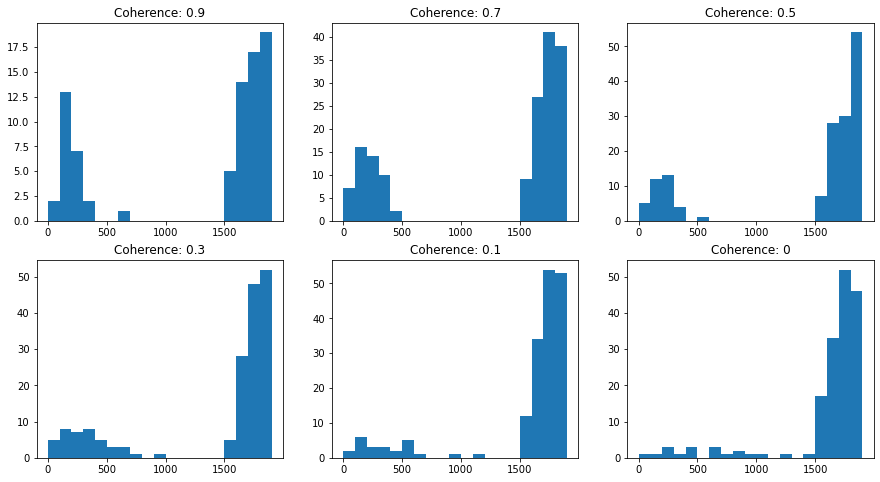

In [131]:
idx = 1
plt.figure(figsize=(15, 8))
for i in [0.9,0.7,0.5,0.3,0.1,0]:
    a = checker_df['coherence_bin'] == i
    groupCo = checker_df.loc[a,:]
    RT = groupCo["decision_time"]
    plt.subplot(2,3,idx)
    plt.hist(RT, bins = np.arange(0,2000,100))
    plt.title("Coherence: " + str(i))
    idx = idx + 1

# plt.savefig("RTrec_noise" + str(rec_noise) + "round" + str(round) + "train0.7test" + str(thres) + ".png")

In [137]:
model2.destruct()